<a href="https://colab.research.google.com/github/kathleenreily/RegressionHouseprices/blob/master/RegressionModelsHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Load the houseprices data from Thinkful's database.

In [1]:
# These are the libraries we use

from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import seaborn as sns
import math
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# with single inquiries we can close the connection 
engine.dispose()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Purpose: 

I will be exploring the relationship between our target variable saleprice and othe features within the data set. Particularly looking at garage, overall quality, and basment features. I will be running multiple assumptions, and models on my equation to confirm which model has the most explanatory power given the data. At the end I will call in some additional factors outside this dataset that might also help explain my target variable, such as inflation rate from 2006 to 2010. 

Step 2: Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [2]:
#explore the dataset to understand which features are objects and the count of objects as well. 
houseprices_df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [3]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [4]:
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


Now we'll look into any missing variables.

In [5]:
total_missing = houseprices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (houseprices_df.isnull().sum()/houseprices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

#you can see there are some variables with missing data, however, we won't be using them in our models so we can let them be

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


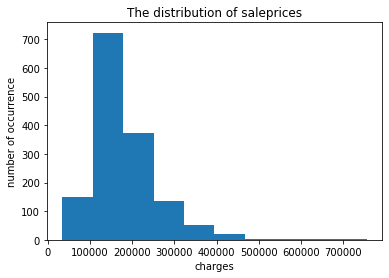

In [6]:
#let's look at the distribution of our target variable which is saleprice

plt.hist(houseprices_df.saleprice)
plt.title("The distribution of saleprices")
plt.xlabel("charges")
plt.ylabel("number of occurrence")
plt.show()

#skewed pretty heavily to the right

In [0]:
#we can use two of our categorical variables street and mszoning as our dummy variables, we do this because there are only two 
#types of values in the column.

houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True).columns)


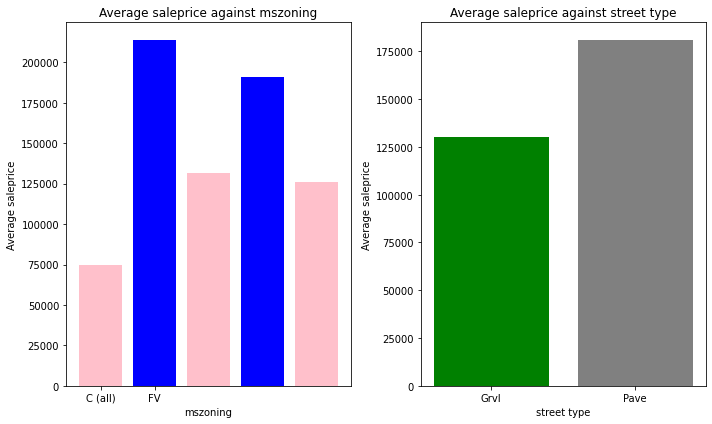

In [8]:
#let's compare the dummies with the target variable saleprice and look at the relationship
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.bar(houseprices_df.groupby("mszoning")["saleprice"].mean().index, houseprices_df.groupby("mszoning")["saleprice"].mean(),
       color=("pink","blue"))
plt.title("Average saleprice against mszoning")
plt.ylabel("Average saleprice")
plt.xlabel("mszoning")
plt.xticks([0,1])

plt.subplot(1,2,2)
plt.bar(houseprices_df.groupby("street")["saleprice"].mean().index, houseprices_df.groupby("street")["saleprice"].mean(),
       color=("green","grey"))
plt.title("Average saleprice against street type")
plt.ylabel("Average saleprice")
plt.xlabel("street type")
plt.xticks([0,1])

plt.tight_layout()
plt.show()

We can see with gravel the price is lower and with paved the price is higher. In C zones the price is lower than in FV zones.

In [9]:
#let's look at correlation before building our model 
houseprices_df.corr()
#overallqual 0.79, grlivarea 0.7, garagecars 0.65, garagearea 0.62, totalbsmtsqf 0.61, 

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917,-0.012020,0.032453,0.031034,-0.032379,0.008916
mssubclass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284,0.171336,0.058288,-0.343353,0.277750,-0.024969
lotfrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799,-0.097092,-0.047950,0.346736,-0.324638,-0.040886
lotarea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843,-0.083895,-0.033092,0.204065,-0.173709,-0.197131
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982,0.171854,-0.064666,0.126972,-0.195515,0.058823
overallcond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856,-0.105671,-0.001215,-0.069669,0.158205,0.042848
yearbuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897,0.237645,-0.089183,0.268064,-0.388683,0.021137
yearremodadd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101,0.208816,-0.065939,0.074221,-0.161815,0.065465
masvnrarea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.0376

Let's build out our linear regression model

In [0]:
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf'] + dummy_column_names]
Y = houseprices_df.saleprice

#grab the OLS stats from the model

In [11]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())

#garage area doesn't have a significant p value so I will drop it. 

lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     534.7
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:19:02   Log-Likelihood:                -17476.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1450   BIC:                         3.502e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.15e+05    1.8e+04     -6.389      

split the data into training and test (20% test)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [13]:
X_train.head()

,const,overallqual,grlivarea,garagecars,totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
151,1.0,5,969,2,969,0,0,1,0,1
262,1.0,8,2574,3,1482,0,0,1,0,1
1037,1.0,8,2263,2,1055,0,0,1,0,1
1183,1.0,5,1130,2,1120,0,0,1,0,1
933,1.0,7,1500,2,1500,0,0,1,0,1


In [0]:
#adding a constant to the baseline of our model
X_train = sm.add_constant(X_train)

In [15]:
#now let's train the model
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     424.9
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:19:02   Log-Likelihood:                -13973.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1158   BIC:                         2.802e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.005e+05   2.05e+04     -4.900      

Our equation is:

saleprice = -1.05 +2.4overallquall +43.7grlivearea +1.8garagecars +24.5totalbsmtsqf +e


Let's check to be sure our model meets all the necessary assumptions. 


Coefficients: 
 [2. 3.]

Intercept: 
 0.9999999997671694


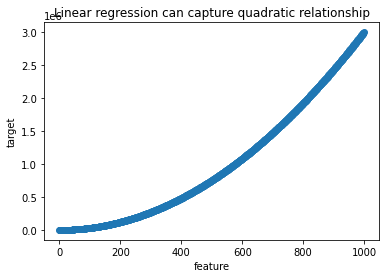

In [16]:
#assumption 1: linearity of model coefficients 

df = pd.DataFrame()

# data from 0 to 999
df["X"] = np.arange(0,1000,1)
# we take the square of X
df["X_sq"] = df["X"]**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df["Y"] = 1 + 2*df["X"] + 3*df["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X","X_sq"]],df["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

#we see that the coefficients are non linear and the relationship between all are quadratic

In [17]:
#assumption 2: E(e) = 0

predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the weather model is: {}".format(np.mean(errors)))

#far from zerio but i do have a constant built in which should keep it close to 0???

Mean of the errors in the weather model is: 1.0784364573351324e-10


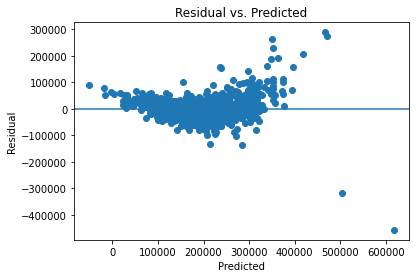

In [18]:
#assumption 3: checking for homoschedasticity
#we see a moderate level of heteroscedasticity but this plot is not enough to get a full test, 
#we need bartlett and levene for pval

plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [19]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

#where the null hypothesis is that the model is homoschedastic, the pval for both tests is <0.05 so we reject the null 
#and in fact our error variance is heteroschedastic. we could have some outliers that could explain this

Bartlett test statistic value is 496.005 and p value is 7.04e-110
Levene test statistic value is 494.786 and p value is 2.19e-101


In [20]:
#assumption 4: low multicolinearity, let's look for variables that are highly correlated beacuse we can't use them if so

feature_corr = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf']]
feature_corr.corr()
#we see some moderate correlation but not enough to eliminate these variables

,overallqual,grlivarea,garagecars,totalbsmtsf
overallqual,1.000000,0.593007,0.600671,0.537808
grlivarea,0.593007,1.000000,0.467247,0.454868
garagecars,0.600671,0.467247,1.000000,0.434585
totalbsmtsf,0.537808,0.454868,0.434585,1.000000


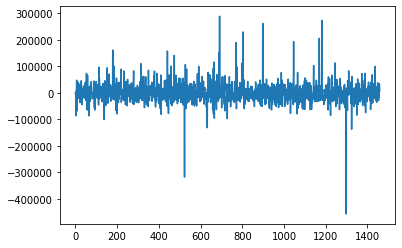

In [21]:
#assumption #5: uncorrelated error terms
plt.plot(errors)
plt.show()
#you can see the errors look pretty correlated, we can also try the autocorrelation function to confirm

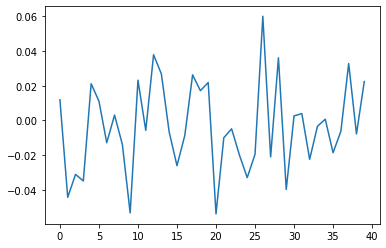

In [22]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

#but here they are very uncorrelated so we can move onto the next assumption test

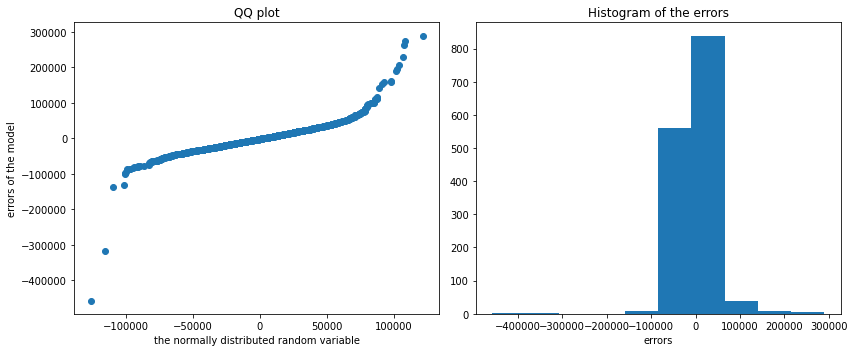

In [23]:
#assumption 6: feature shouldn't be correlated with errors, 

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

#we see the errors are normally distributed with the histogram and the QQ chart but, 
#let's also check with jarque ber and normal test

In [24]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

#both p values are <0.05 so our errors are not normally distributed, and the exogeneity assumption is not violated

Jarque-Bera test statistics is 37667.56505996783 and p value is 0.0
Normality test statistics is 406.41582338755063 and p value is 5.59661294045478e-89


Let's use various evaluation metrics to make predictions on our model

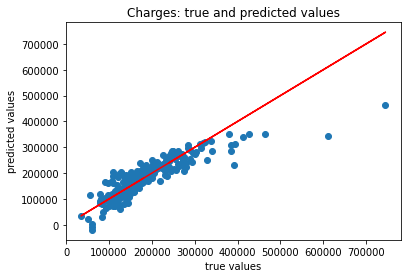

Mean absolute error of the prediction is: 25698.400299068853
Mean squared error of the prediction is: 1560222128.7468565
Root mean squared error of the prediction is: 39499.647197751736
Mean absolute percentage error of the prediction is: 15.661233556978793


In [25]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

#with the exception of MAPE the predictions are too high but the data seems to fit the line quite well

In [26]:
#I'm going to make a new variable that comines first floor and second floor square footage to determine if that
#impacts the fit of our model, the two features seem like they would increase or decrease the sale price

houseprices_df['first_second_sqf'] = houseprices_df['firstflrsf']+houseprices_df['secondflrsf']

# Y is the target variable, and we are going to log the saleprice to see if this helps provide accuracy to our model
Y = np.log1p(houseprices_df['saleprice'])
# X is the feature set
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'first_second_sqf'] + dummy_column_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())
#we can see that if we include the second and first floor square foot variable and log the target, our R^2 goes up to 81.4% from 76%
#however, the AIC and BIC are extremely low, in the negatives. the p val is significant however for our new variable, and
#p val for the f test is 0 too which is great 
#we can also look at the prediction indicators below and see that they dropped dramatically, and that the data fits the line
#much better. 

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     506.7
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:19:04   Log-Likelihood:                 404.41
No. Observations:                1168   AIC:                            -786.8
Df Residuals:                    1157   BIC:                            -731.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.3605      0.093  

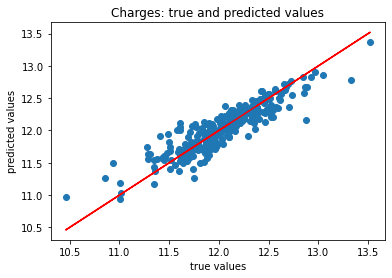

Mean absolute error of the prediction is: 0.13085892898858195
Mean squared error of the prediction is: 0.030846785674260406
Root mean squared error of the prediction is: 0.17563253022791764
Mean absolute percentage error of the prediction is: 1.0946606754608168


In [27]:
# We are making predictions here now that we have altered the model, and we can see our 
#evaluation metrics have dropped significantly and the data is tighter and more centralized to the line, so we like this model
#for now
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

I'm going to build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [28]:
#first standard linear regression
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

#the generalization gap is extremely tight, and the other fit measures are excellent

R-squared of the model in training set is: 0.8140999527004293
-----Test set statistics-----
R-squared of the model in test set is: 0.8150069528462823
Mean absolute error of the prediction is: 0.13085892898858545
Mean squared error of the prediction is: 0.030846785674261572
Root mean squared error of the prediction is: 0.17563253022792097
Mean absolute percentage error of the prediction is: 1.0946606754608401


In [29]:
#now let's try the Lasso Model
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

#this could be a descent model, our R^2 and adjusted R^2 have a medium sized gap, the generalization gap is small and the other
#error metrics are low

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0013312851260176561
Mean absolute error of the prediction is: 0.31782438122584333
Mean squared error of the prediction is: 0.16696763481899562
Root mean squared error of the prediction is: 0.40861673340551735
Mean absolute percentage error of the prediction is: 2.6437648221337358


In [30]:
#let's try Ridge Regression Model

from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**37) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

#again decent generalization gap and good error scores

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0013312851260176561
Mean absolute error of the prediction is: 0.31782438122584333
Mean squared error of the prediction is: 0.16696763481899562
Root mean squared error of the prediction is: 0.40861673340551735
Mean absolute percentage error of the prediction is: 2.6437648221337358


In [31]:
#ElasticNet Regression Model

from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

#again decent generalization gap and good error scores

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0013312851260176561
Mean absolute error of the prediction is: 0.31782438122584333
Mean squared error of the prediction is: 0.16696763481899562
Root mean squared error of the prediction is: 0.40861673340551735
Mean absolute percentage error of the prediction is: 2.6437648221337358


So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [32]:
#let's explore year sold data so that I can understand 

import statistics
houseprices_df['yrsold'].mean()

2007.8157534246575

In [33]:
houseprices_df['yrsold'].mode()

0    2009
dtype: int64

The mode year that most houses were sold in 2009 we can take this into account given that was right around the time the subprime housing bubble burst. 

In [0]:
#i found inflation rate data from 2006 to 2010, source: usinflationcalculator.com and then created a small dataframe to merge with
#house prices (https://www.usinflationcalculator.com/inflation/historical-inflation-rates/)

inflation_year = {2006: 3.2,
                 2007: 2.8,
                  2008: 3.8,
                  2009: -0.4,
                  2010: 1.6}


In [51]:
houseprices_df['inflation'] = houseprices_df.yrsold.map(inflation_year) #this creates a new column called interest rate
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,first_second_sqf,inflation
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,0,0,1,0,1,1710,3.8
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,0,0,1,0,1,1262,2.8
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,0,0,1,0,1,1786,3.8
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,0,0,1,0,1,1717,3.2
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,0,0,1,0,1,2198,3.8


Now that we have inflation numbers to run in our model let's see if this helps explain why the most homes were sold in year 2009

In [53]:
Y = np.log1p(houseprices_df['saleprice'])
# X is the feature set
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'first_second_sqf', 'inflation', 'yrsold'] + dummy_column_names]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     421.9
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:17:11   Log-Likelihood:                 404.83
No. Observations:                1168   AIC:                            -783.7
Df Residuals:                    1155   BIC:                            -717.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.7605      9.957  

In [54]:
#first standard linear regression
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8142350993338758
-----Test set statistics-----
R-squared of the model in test set is: 0.8158386886708647
Mean absolute error of the prediction is: 0.1306661438024361
Mean squared error of the prediction is: 0.030708097344547318
Root mean squared error of the prediction is: 0.17523726014905425
Mean absolute percentage error of the prediction is: 1.0931064906473584


In [55]:
#i do want to look at the correlation between saleprice yrsold and inflation

yr_inf_sale_corr = houseprices_df[['saleprice', 'inflation', 'yrsold']]
yr_inf_sale_corr.corr()

#we see that year sold and the inflation rate are moderately correlated at 0.63, which means low interest rates

,saleprice,inflation,yrsold
saleprice,1.000000,0.008141,-0.028923
inflation,0.008141,1.000000,-0.631707
yrsold,-0.028923,-0.631707,1.000000


Conclusions: 

We can see that when calling in inflation rates particularly from 2006 to 2010 there is a strong negative correlation between year sold and inflation. Meaning if most of the houses were sold in 2009 then the inflation rate must have been extremely low, which we see in the dataframe above. 

When running multiple possible models also, such as Ridge and OLS, we see the best model to use based on the generalization gap and low error metrics is OLS standard linear regression. 